<a href="https://githubtocolab.com/neurallatents/nlb_tools/blob/main/examples/tutorials/basic_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic `nlb_tools` demo

This notebook will briefly explain how NLB'21 is structured and then demonstrate how to use `nlb_tools` to load from the provided dataset files, prepare the data for model input or submission, and evaluate model performance.

## Introduction

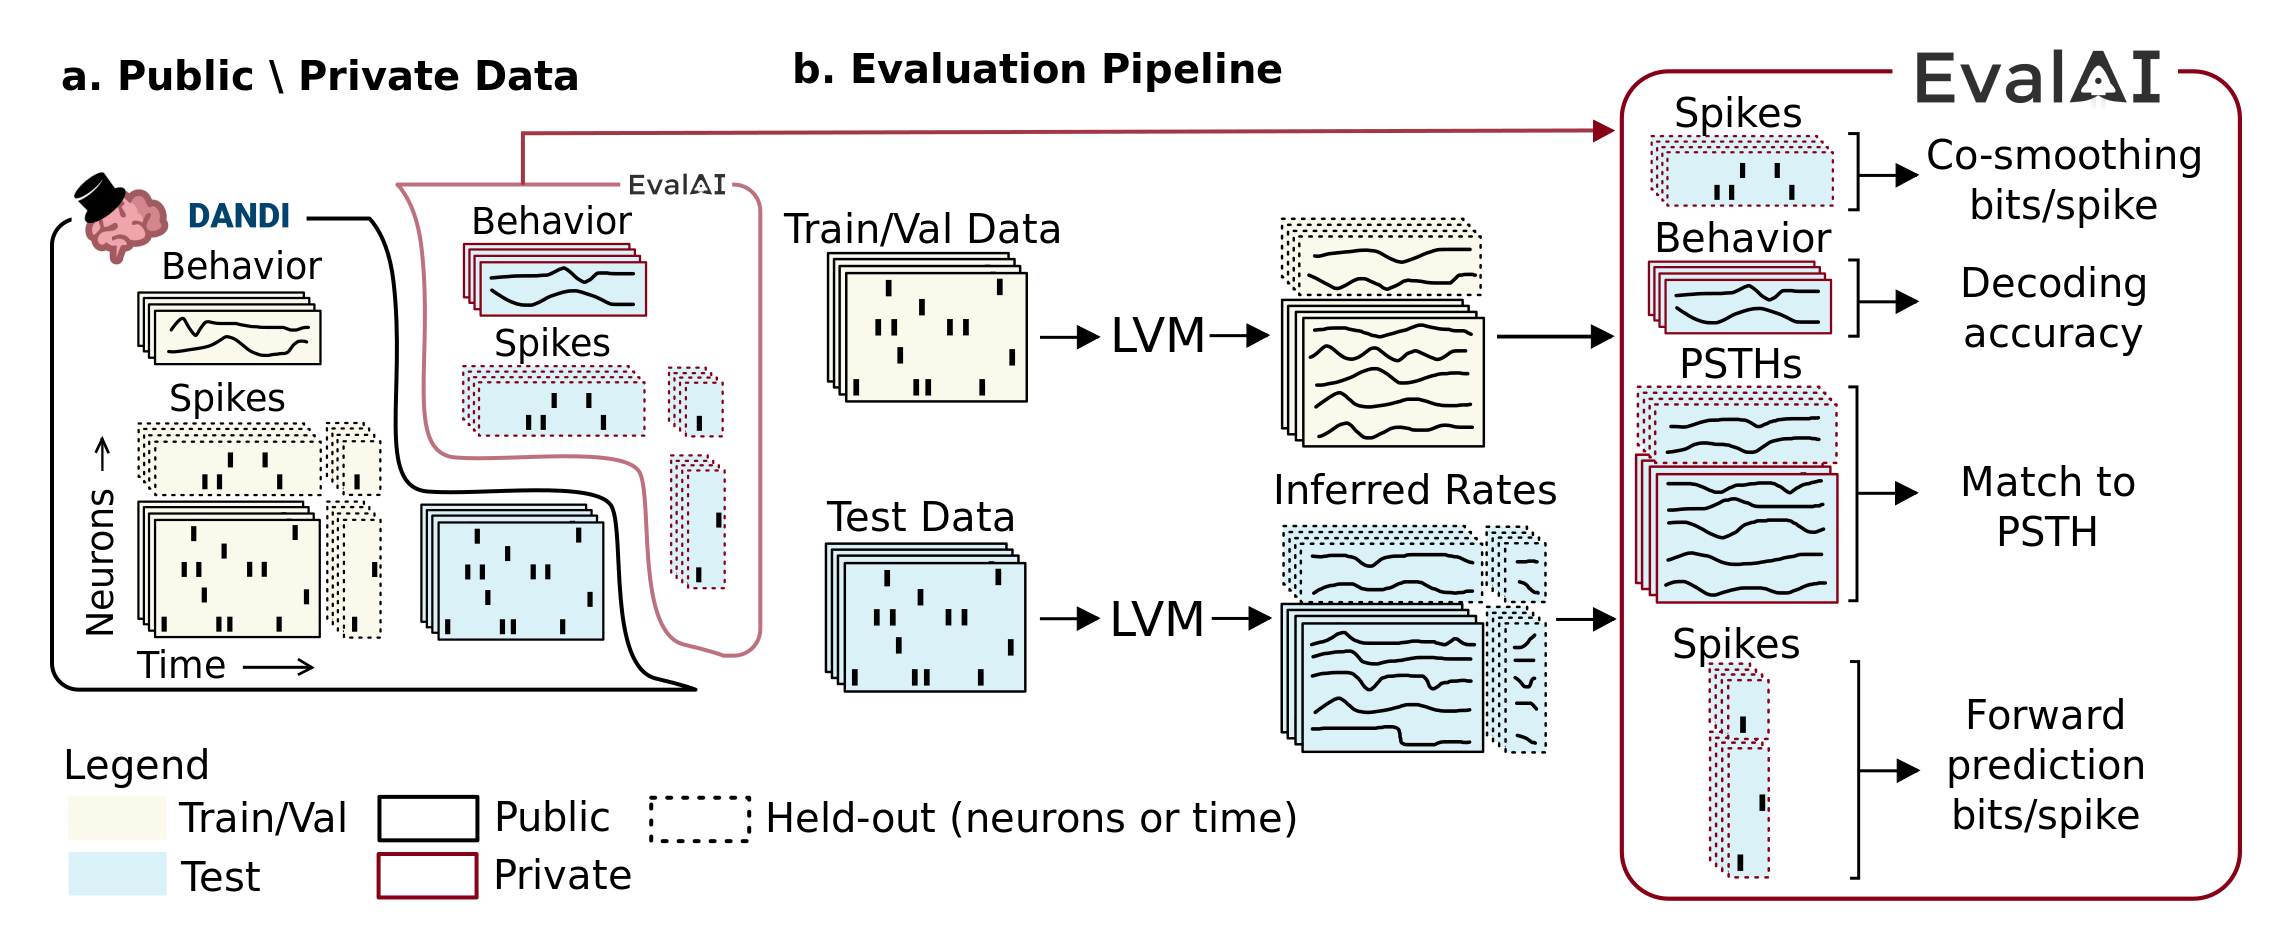

In [1]:
from IPython.display import display, Image
display(Image(filename="img/pipeline.png", embed=True))

### Benchmark challenge

In the NLB'21, participants are tasked with inferring the firing rates of a held-out portion of neurons based on the spiking activity of some held-in neurons, a procedure called co-smoothing. The training data include held-in and held-out spiking activity as well as trial information and behavioral data if applicable. The test data only contain held-in spiking activity from specific segments of trials.

The challenge is hosted on the platform EvalAI, where submissions can be uploaded, evaluated, and displayed on a leaderboard. The EvalAI challenge has two phases: Validation and Test. In the Validation phase, performance is evaluated on a designated val split within the training data. This phase is completely optional and is provided for building familiarity with the EvalAI platform and sanity checking that local results match EvalAI evaluation. In the Test phase, performance is evaluated on the provided test data. This phase will be used to determine winners of our benchmark competition. Note that you do not need to follow our train/val split designations when developing and evaluating your model, as they are provided solely for the optional Validation phase.

Submissions in the benchmark competition will be ranked only by performance on co-smoothing at 5 ms resolution. However, we have included a number of other metrics that we feel may be useful to the community, and we evaluate 20 ms resolution submissions as well. Other bin widths can be used for model training and local evaluation, but EvalAI only supports 5 and 20 ms resolution submissions.

### Datasets

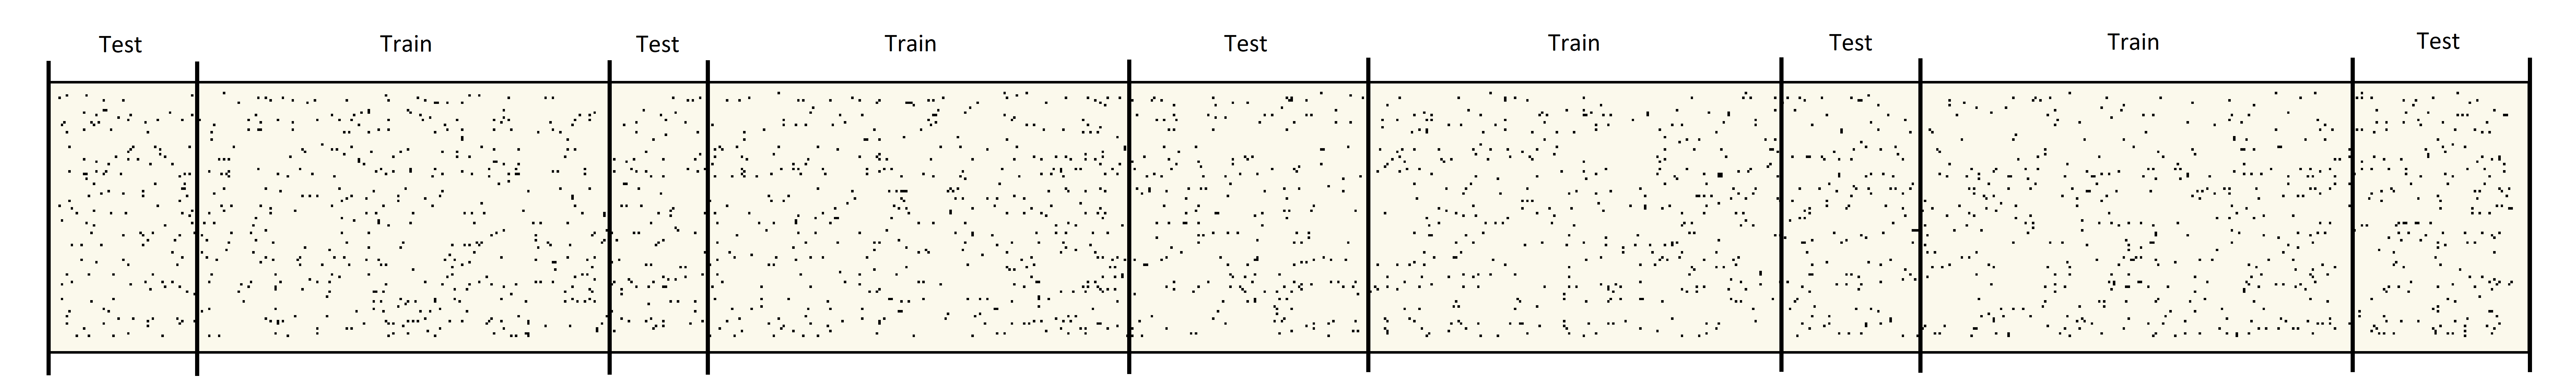

In [2]:
from IPython.display import display, Image
display(Image(filename="img/split.png", embed=True))

Our benchmark involves four different datasets spanning various tasks and brain areas: MC_Maze, MC_RTT, Area2_Bump, and DMFC_RSG. For more information about the datasets themselves, please see the [datasets page](https://neurallatents.github.io/dataset.html) of our main site.

For the MC_RTT, Area2_Bump, and DMFC_RSG datasets, the continuous data were split into several chunks for the training and test splits, as shown above. (The val split is a random subset of the training data.) As a result, the data contains several discontinuities, which are indicated by NaNs. The MC_Maze and scaling datasets are entirely trialized already, so all trials are separated by NaNs. Train, val, and test trials were randomly selected instead of using the procedure shown above. For all datasets, the test data contains very specific segments of the continuous data, and all segments are separated by NaNs.

## 1. Setup

Below, we import the necessary functions from `nlb_tools` and additional standard packages.

`nlb_tools` uses `logging` for warning messages and event tracking. Setting the logging level to `logging.INFO` prints out both info and warning messages, which is useful for demonstration but may be unnecessary for your own scripts.

In [3]:
## Install packages if necessary
# !pip install -U scikit-learn
# !pip install git+https://github.com/neurallatents/nlb_tools.git

In [4]:
from nlb_tools.nwb_interface import NWBDataset
from nlb_tools.make_tensors import make_train_input_tensors, make_eval_input_tensors, make_eval_target_tensors, save_to_h5
from nlb_tools.evaluation import evaluate

import numpy as np
import pandas as pd
import h5py

import logging
logging.basicConfig(level=logging.INFO)

In [5]:
## If necessary, download dataset from DANDI
# !pip install dandi
# !dandi download https://dandiarchive.org/dandiset/000138 # replace URL with URL for dataset you want
# # URLS are:
# # - MC_Maze: https://dandiarchive.org/dandiset/000128
# # - MC_RTT: https://dandiarchive.org/dandiset/000129
# # - Area2_Bump: https://dandiarchive.org/dandiset/000127
# # - DMFC_RSG: https://dandiarchive.org/dandiset/000130
# # - MC_Maze_Large: https://dandiarchive.org/dandiset/000138
# # - MC_Maze_Medium: https://dandiarchive.org/dandiset/000139
# # - MC_Maze_Small: https://dandiarchive.org/dandiset/000140

## 2. Loading data

To facilitate working with the NWB format used with our datasets, we are providing the `NWBDataset` class, which can load from the dataset files and perform simple preprocessing operations. Note that this class is specifically written for the NWB files we have created, so it will likely not work with other NWB files, particularly from different recording modalities.

To load a dataset, you can simply create an `NWBDataset` and provide the path to the dataset files. To load one file, you can pass in the path to the specific file. To load multiple files, you should pass in the path to the directory containing the files and optionally a file prefix to filter out specific files. The data from the files will be concatenated with NaN margins indicating when the data is discontinuous.

In [6]:
## Load data from NWB file

dataset_name = 'mc_maze_large'
datapath = '~/lvm/code/dandi/000138/sub-Jenkins/'
dataset = NWBDataset(datapath)

INFO:nlb_tools.nwb_interface:Loading /snel/home/fpei/lvm/code/dandi/000128/sub-Jenkins/sub-Jenkins_ses-large_desc-test_ecephys.nwb
INFO:nlb_tools.nwb_interface:Loading /snel/home/fpei/lvm/code/dandi/000128/sub-Jenkins/sub-Jenkins_ses-large_desc-train_behavior+ecephys.nwb



If you run into memory issues when loading or preprocessing the dataset, you may find it useful to skip loading some of the unnecessary data. You can do that with the `skip_fields` argument in `NWBDataset` initialization:
```
dataset = NWBDataset(datapath, prefix, skip_fields=['joint_ang', 'joint_vel', 'muscle_len', 'muscle_vel'])
```

### `NWBDataset` attributes

The loaded data is primarily stored in two DataFrames: `data` and `trial_info`.
* `data` contains the continuous recorded data, like spike counts and kinematics. Most importantly, spiking data from held-in units is labeled `spikes` and data from held-out units is labeled `heldout_spikes`.
* `trial_info` contains trial-related data like trial start and end times, reach direction, etc. The field `split`, common to all of our provided datasets, indicates whether a given trial is in the train or val split or if it is to be ignored (`'none'`).

The class also has a `bin_width` attribute which contains the continuous data's bin width in milliseconds and a `descriptions` field storing information about the various columns in `data` and `trial_info`.

In [7]:
## View dataset.data
dataset.data

signal_type             cursor_pos            eye_pos           hand_pos  \
channel                          x          y       x      y           x   
clock_time                                                                 
0 days 00:00:00                NaN        NaN     NaN    NaN         NaN   
0 days 00:00:00.001000         NaN        NaN     NaN    NaN         NaN   
0 days 00:00:00.002000         NaN        NaN     NaN    NaN         NaN   
0 days 00:00:00.003000         NaN        NaN     NaN    NaN         NaN   
0 days 00:00:00.004000         NaN        NaN     NaN    NaN         NaN   
...                            ...        ...     ...    ...         ...   
0 days 00:26:05.016000  125.097605 -72.891685   -56.0 -184.6  125.250633   
0 days 00:26:05.017000  125.107307 -72.887748   -56.1 -184.1  125.258073   
0 days 00:26:05.018000  125.130154 -72.889063   -54.2 -184.3  125.265411   
0 days 00:26:05.019000  125.163190 -72.894271   -54.0 -184.3  125.272702   
0 days 00:26:05.020000  125.200000 -72.900000   -54.2 -183.7  125.279774   

signal_type                         hand_vel            heldout_spikes       \
channel                          y         x          y           1031 1051   
clock_time                                                                    
0 days 00:00:00                NaN       NaN        NaN            NaN  NaN   
0 days 00:00:00.001000         NaN       NaN        NaN            NaN  NaN   
0 days 00:00:00.002000         NaN       NaN        NaN            NaN  NaN   
0 days 00:00:00.003000         NaN       NaN        NaN            NaN  NaN   
0 days 00:00:00.004000         NaN       NaN        NaN            NaN  NaN   
...                            ...       ...        ...            ...  ...   
0 days 00:26:05.016000 -107.815282  7.452204  20.090608            0.0  0.0   
0 days 00:26:05.017000 -107.794590  7.389157  21.253591            0.0  0.0   
0 days 00:26:05.018000 -107.772775  7.314626  22.264360            0.0  0.0   
0 days 00:26:05.019000 -107.750062  7.181400  23.165218            0.0  0.0   
0 days 00:26:05.020000 -107.726445  7.071878  23.617009            0.0  0.0   

signal_type             ... spikes                                          \
channel                 ...   2741 2743 2761 2771 2781 2791 2801 2881 2941   
clock_time              ...                                                  
0 days 00:00:00         ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.001000  ...    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.002000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.003000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.004000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                     ...    ...  ...  ...  ...  ...  ...  ...  ...  ...   
0 days 00:26:05.016000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:26:05.017000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:26:05.018000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:26:05.019000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:26:05.020000  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

signal_type                  
channel                2951  
clock_time                   
0 days 00:00:00         0.0  
0 days 00:00:00.001000  0.0  
0 days 00:00:00.002000  0.0  
0 days 00:00:00.003000  0.0  
0 days 00:00:00.004000  0.0  
...                     ...  
0 days 00:26:05.016000  0.0  
0 days 00:26:05.017000  0.0  
0 days 00:26:05.018000  0.0  
0 days 00:26:05.019000  0.0  
0 days 00:26:05.020000  0.0  

[1565021 rows x 170 columns]

In [8]:
## View dataset.trial_info
dataset.trial_info

,trial_id,start_time,end_time,move_onset_time,split,trial_type,trial_version,maze_id,success,target_on_time,go_cue_time,rt,delay,num_targets,target_pos,num_barriers,barrier_pos,active_target
0,0,0 days 00:00:00,0 days 00:00:00.700000,0 days 00:00:00.250000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0 days 00:00:00.800000,0 days 00:00:01.500000,0 days 00:00:01.050000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0 days 00:00:01.600000,0 days 00:00:02.300000,0 days 00:00:01.850000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0 days 00:00:02.400000,0 days 00:00:03.100000,0 days 00:00:02.650000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0 days 00:00:03.200000,0 days 00:00:03.900000,0 days 00:00:03.450000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,0 days 00:25:49.600000,0 days 00:25:52.636000,0 days 00:25:51.501000,train,8.0,1.0,38.0,True,0 days 00:25:50.405000,0 days 00:25:51.153000,348.0,748.0,1.0,"[[-105, 76]]",9.0,"[[74, -102, 11, 53], [86, -44, 14, 11], [103, ...",0.0
596,596,0 days 00:25:52.700000,0 days 00:25:55.746000,0 days 00:25:54.595000,train,11.0,2.0,80.0,True,0 days 00:25:53.467000,0 days 00:25:54.116000,479.0,649.0,3.0,"[[123, -81], [-130, -13], [123, 71]]",8.0,"[[-65, -15, 14, 51], [-79, -55, 55, 6], [-103,...",2.0
597,597,0 days 00:25:55.800000,0 days 00:25:58.801000,0 days 00:25:57.701000,val,7.0,2.0,37.0,True,0 days 00:25:56.545000,0 days 00:25:57.410000,291.0,865.0,3.0,"[[124, -79], [103, 83], [-105, 76]]",9.0,"[[74, -102, 11, 53], [86, -44, 14, 11], [103, ...",1.0
598,598,0 days 00:25:58.900000,0 days 00:26:01.956000,0 days 00:26:00.777000,train,7.0,1.0,37.0,True,0 days 00:25:59.613000,0 days 00:26:00.479000,298.0,866.0,1.0,"[[103, 83]]",9.0,"[[74, -102, 11, 53], [86, -44, 14, 11], [103, ...",0.0


In [9]:
## View additional fields
print(f'bin_width: {dataset.bin_width}', end='\n\n')
print(f'fields: {list(dataset.descriptions.keys())}', end='\n\n')

randkey = np.random.choice(list(dataset.descriptions.keys()))
print(f'{randkey}: {dataset.descriptions[randkey]}')

bin_width: 1

fields: ['start_time', 'stop_time', 'move_onset_time', 'split', 'trial_type', 'trial_version', 'maze_id', 'success', 'target_on_time', 'go_cue_time', 'rt', 'delay', 'num_targets', 'target_pos', 'num_barriers', 'barrier_pos', 'active_target', 'cursor_pos', 'eye_pos', 'hand_pos', 'hand_vel']

trial_type: A number representing the maze configuration that was used for the trial


As you can see, in the test split, which was loaded first, all data other than held-in spiking activity is hidden.

### `NWBDataset` methods

In addition to loading the data, `NWBDataset` can perform a variety of basic preprocessing tasks, like trializing data, resampling, and smoothing spikes. These may be unnecessary, particularly if you plan to use another programming language for modeling, but you can refer to the code documentation for details and examples.

## 3. Modeling pipeline

The module `make_tensors` contains functions that shape data into the format we use and expect for submission and evaluation. In general, the data should be in the form of 3d arrays with the first dimension being trials, second being time, and third being channels/features. Here is a brief summary of the main high-level functions provided:
* `make_train_input_tensors` - Creates arrays containing training data that can be used to fit a model.
* `make_eval_input_tensors` - Creates arrays containing data that can be passed through a model to generate predictions for evaluation or validation.
* `make_eval_target_tensors` - Creates arrays containing true target values for submission evaluation. This function cannot be used for the test split, since the test split evaluation data is not publicly available, but it is what we use to create our evaluation data files.

All three functions can save the output in HDF5 format with `save_file=True` and/or return it as a python dictionary with `return_dict=True` (both are `True` by default). The .h5 files will have the same structure as the python dictionaries shown here. In addition, these functions all by default use parameters defined in `PARAMS` in `make_tensors.py`, which will create arrays with our desired specifications for each dataset. These parameters can be changed with the `update_params` argument if desired.

### Making input
First, we will create arrays for input with `make_train_input_tensors` and `make_eval_input_tensors`. You can choose to run the notebook for the validation phase or the test phase, but results for the test phase cannot be viewed unless you submit to EvalAI.

In [10]:
## Dataset preparation

# Choose the phase here, either 'val' or 'test'
phase = 'val'

# Choose bin width and resample
bin_width = 5
dataset.resample(bin_width)

# Create suffix for group naming later
suffix = '' if (bin_width == 5) else f'_{int(bin_width)}'

INFO:nlb_tools.nwb_interface:Resampling data to 5 ms.


In [11]:
## Make train data

# Create input tensors, returned in dict form
train_split = 'train' if (phase == 'val') else ['train', 'val']
train_dict = make_train_input_tensors(dataset, dataset_name=dataset_name, trial_split=train_split, save_file=False)

# Show fields of returned dict
print(train_dict.keys())

# Unpack data
train_spikes_heldin = train_dict['train_spikes_heldin']
train_spikes_heldout = train_dict['train_spikes_heldout']

# Print 3d array shape: trials x time x channel
print(train_spikes_heldin.shape)

INFO:nlb_tools.nwb_interface:Aligned 375 trials to move_onset_time with offset of (-250, 450) ms and margin of 0.


dict_keys(['train_spikes_heldin', 'train_spikes_heldout'])
(375, 140, 122)


In [12]:
## Make eval data

# Split for evaluation is same as phase name
eval_split = phase
# Make data tensors
eval_dict = make_eval_input_tensors(dataset, dataset_name=dataset_name, trial_split=eval_split, save_file=False)
print(eval_dict.keys()) # only includes 'eval_spikes_heldout' if available
eval_spikes_heldin = eval_dict['eval_spikes_heldin']

print(eval_spikes_heldin.shape)

INFO:nlb_tools.nwb_interface:Aligned 125 trials to move_onset_time with offset of (-250, 450) ms and margin of 0.


dict_keys(['eval_spikes_heldin', 'eval_spikes_heldout'])
(125, 140, 122)


If you plan to use a programming language other than Python, you will likely want to save the tensors created above with `save_file=True` and implement the remaining modeling steps in your preferred language.

Regardless of your modeling implementation, the resulting rate prediction tensors should be the same shape as the input tensors (when corresponding input data is available). The shapes of all submission tensors is listed at the end of this tutorial for reference.

### Generating rate predictions

Now, we will generate rate predictions using spike smoothing and Poisson regression. Note that predicted rates will be in units of **spikes/bin**, and that the Poisson regression requires `scikit-learn>=0.23`. Feel free to replace that portion of the code with linear regression or your own implementation of Poisson regression if you have an older version of scikit-learn.

In [13]:
## Define helper function for training Poisson regressor

from sklearn.linear_model import PoissonRegressor

def fit_poisson(train_input, eval_input, train_output, alpha=0.0):
    train_pred = []
    eval_pred = []
    # train Poisson GLM for each output column
    for chan in range(train_output.shape[1]):
        pr = PoissonRegressor(alpha=alpha, max_iter=500)
        pr.fit(train_input, train_output[:, chan])
        train_pred.append(pr.predict(train_input))
        eval_pred.append(pr.predict(eval_input))
    train_pred = np.vstack(train_pred).T
    eval_pred = np.vstack(eval_pred).T
    return train_pred, eval_pred

In [14]:
## Smooth spikes

# Assign useful variables
tlength = train_spikes_heldin.shape[1]
num_train = train_spikes_heldin.shape[0]
num_eval = eval_spikes_heldin.shape[0]
num_heldin = train_spikes_heldin.shape[2]
num_heldout = train_spikes_heldout.shape[2]

# Smooth spikes with 40 ms std gaussian
import scipy.signal as signal
kern_sd_ms = 40
kern_sd = int(round(kern_sd_ms / dataset.bin_width))
window = signal.gaussian(kern_sd * 6, kern_sd, sym=True)
window /= np.sum(window)
filt = lambda x: np.convolve(x, window, 'same')

train_spksmth_heldin = np.apply_along_axis(filt, 1, train_spikes_heldin)
eval_spksmth_heldin = np.apply_along_axis(filt, 1, eval_spikes_heldin)

In [15]:
## Generate rate predictions

# Reshape data to 2d for regression
train_spksmth_heldin_s = train_spksmth_heldin.reshape(-1, train_spksmth_heldin.shape[2])
eval_spksmth_heldin_s = eval_spksmth_heldin.reshape(-1, eval_spksmth_heldin.shape[2])
train_spikes_heldout_s = train_spikes_heldout.reshape(-1, train_spikes_heldout.shape[2])

# Train Poisson regressor from log of held-in smoothed spikes to held-out spikes
train_spksmth_heldout_s, eval_spksmth_heldout_s = fit_poisson(
    np.log(train_spksmth_heldin_s + 1e-4), # add constant offset to prevent taking log of 0
    np.log(eval_spksmth_heldin_s + 1e-4),
    train_spikes_heldout_s,
    alpha=0.1,
)

# Reshape data back to the same 3d shape as the input arrays
train_rates_heldin = train_spksmth_heldin_s.reshape((num_train, tlength, num_heldin))
train_rates_heldout = train_spksmth_heldout_s.reshape((num_train, tlength, num_heldout))
eval_rates_heldin = eval_spksmth_heldin_s.reshape((num_eval, tlength, num_heldin))
eval_rates_heldout = eval_spksmth_heldout_s.reshape((num_eval, tlength, num_heldout))

### Making the submission
Now that we have rate predictions, we can prepare our submission for evaluation.

The dict constructed below has the same structure as the submission HDF5 files: top-level keys (HDF5 groups) specify the dataset and bin width, while lower-level keys (HDF5 datasets) specify which portion of the data is contained in the array.

In [16]:
## Prepare submission data

output_dict = {
    dataset_name + suffix: {
        'train_rates_heldin': train_rates_heldin,
        'train_rates_heldout': train_rates_heldout,
        'eval_rates_heldin': eval_rates_heldin,
        'eval_rates_heldout': eval_rates_heldout
    }
}

To save this as an .h5 file for evaluation on EvalAI, you can use the `save_to_h5` method in `make_tensors.py`, which will write the dict to an .h5 file while preserving the nested structure:

```
save_to_h5(output_dict, "submission.h5")
```

Note that the three scaling datasets, MC_Maze_Large, MC_Maze_Medium, and MC_Maze_Small, must be saved in the same file for proper evaluation on EvalAI. This can be done by providing the same path to `save_to_h5` for each dataset or by combining the saved HDF5 files afterwards with `combine_h5`, also found in `make_tensors.py`. All other datasets can be saved and submitted in separate files.

### Making the evaluation data

Finally, we will create the arrays used to evaluate the submission with `make_eval_target_tensors`. The resulting dict or HDF5 file will have a similar structure to the submission data, but it will contain only the data necessary for evaluation. Note that computing PSTHs may be slow and memory-intensive, since we re-load the entire dataset, smooth spikes, and then resample to the current bin width. If you run into any issues, you can simply set `include_psth=False` and PSTH match will not be evaluated.

In [17]:
## Make data to evaluate predictions with

# Reset logging level to hide excessive info messages
logging.getLogger().setLevel(logging.WARNING)

# If 'val' phase, make the target data
if phase == 'val':
    # Note that the RTT task is not well suited to trial averaging, so PSTHs are not made for it
    target_dict = make_eval_target_tensors(dataset, dataset_name=dataset_name, train_trial_split='train', eval_trial_split='val', include_psth=True, save_file=False)

    # Demonstrate target_dict structure
    print(target_dict.keys())
    print(target_dict[dataset_name + suffix].keys())

dict_keys(['mc_maze_large'])
dict_keys(['eval_spikes_heldout', 'train_behavior', 'eval_behavior', 'eval_spikes_heldin_forward', 'eval_spikes_heldout_forward', 'psth'])


## 4. Evaluation

The file `evaluation.py` contains code that is nearly identical to the evaluation script used for our challenge on EvalAI. (The only changes were to allow for evaluation with Python dicts as well as .h5 files.) 

For each dataset, two metrics will always be calculated: negative log likelihood of heldout spikes in the 'test' (or 'val') split given your rate predictions, decoding accuracy/correlation of a behavioral correlate. For datasets other than RTT, match to empirical PSTHs will also be computed. Finally, if forward rate predictions are submitted, negative log likelihood of forward prediction spiking data will be evaluated as well. The exact evaluation details for all datasets are described in more detail on our EvalAI challenge page.

In [18]:
## Run evaluation

# Set logging level again
logging.getLogger().setLevel(logging.INFO)

if phase == 'val':
    print(evaluate(target_dict, output_dict))

INFO:nlb_tools.evaluation:Starting Evaluation.....
INFO:nlb_tools.evaluation:Evaluating mc_maze_large
INFO:nlb_tools.evaluation:Completed evaluation


[{'mc_maze_scaling_split': {'[500] co-bps': 0.2251078100706322, '[500] vel R2': 0.5418582439794997, '[500] psth R2': -1.64198917395823}}]


## Summary

In this notebook, we:
* briefly gave an overview of our benchmark challenge
* introduced `NWBDataset` as a utility for loading from our NWB files and manipulating/processing data
* demonstrated key high-level functions from `make_tensors.py` for formatting data into tensors for model input and evaluation
* generated rate predictions using spike smoothing and ran evaluation using `evaluation.py`

With this, you should be prepared to start applying your own methods for the benchmark. If you would like to see a more effective method applied to the data, please refer to `gpfa_example.ipynb` and `slds_example.ipynb`. The SLDS notebook also demonstrates the submission of future time-step rate predictions, if you are interested in submitting for that metric. Finally, note that `nwb_interface.py` and `make_tensors.py` contain many more functions not shown here that we have found useful in testing various modeling methods, so it may be beneficial to browse through those files.

## Appendix

The following table lists tensor shapes for all submission tensors:

| Dataset | Phase | Bin size | 'train_rates_heldin' | 'train_rates_heldout' | 'eval_rates_heldin' | 'eval_rates_heldout' | 'eval_rates_heldin_forward' | 'eval_rates_heldout_forward' |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| MC_Maze | 'val' | 5 ms | (1721, 140, 137) | (1721, 140, 45) | (574, 140, 137) | (574, 140, 45) | (574, 40, 137) | (574, 40, 45) |
|  |  | 20 ms | (1721, 35, 137) | (1721, 35, 45) | (574, 35, 137) | (574, 35, 45) | (574, 10, 137) | (574, 10, 45) |
|  | 'test' | 5 ms | (2295, 140, 137) | (2295, 140, 45) | (574, 140, 137) | (574, 140, 45) | (574, 40, 137) | (574, 40, 45) |
|  |  | 20 ms | (2295, 35, 137) | (2295, 35, 45) | (574, 35, 137) | (574, 35, 45) | (574, 10, 137) | (574, 10, 45) |
| MC_RTT | 'val' | 5 ms | (810, 120, 98) | (810, 120, 32) | (270, 120, 98) | (270, 120, 32) | (270, 40, 98) | (270, 40, 32) |
|  |  | 20 ms | (810, 30, 98) | (810, 30, 32) | (270, 30, 98) | (270, 30, 32) | (270, 10, 98) | (270, 10, 32) |
|  | 'test' | 5 ms | (1080, 120, 98) | (1080, 120, 32) | (272, 120, 98) | (272, 120, 32) | (272, 40, 98) | (272, 40, 32) |
|  |  | 20 ms | (1080, 30, 98) | (1080, 30, 32) | (272, 30, 98) | (272, 30, 32) | (272, 10, 98) | (272, 10, 32) |
| Area2_Bump | 'val' | 5 ms | (272, 120, 49) | (272, 120, 16) | (92, 120, 49) | (92, 120, 16) | (92, 40, 49) | (92, 40, 16) |
|  |  | 20 ms | (272, 30, 49) | (272, 30, 16) | (92, 30, 49) | (92, 30, 16) | (92, 10, 49) | (92, 10, 16) |
|  | 'test' | 5 ms | (364, 120, 49) | (364, 120, 16) | (98, 120, 49) | (98, 120, 16) | (98, 40, 49) | (98, 40, 16) |
|  |  | 20 ms | (364, 30, 49) | (364, 30, 16) | (98, 30, 49) | (98, 30, 16) | (98, 10, 49) | (98, 10, 16) |
| DMFC_RSG | 'val' | 5 ms | (741, 300, 45) | (741, 300, 15) | (248, 300, 45) | (248, 300, 15) | (248, 40, 45) | (248, 40, 15) |
|  |  | 20 ms | (741, 75, 45) | (741, 75, 15) | (248, 75, 45) | (248, 75, 15) | (248, 10, 45) | (248, 10, 15) |
|  | 'test' | 5 ms | (989, 300, 45) | (989, 300, 15) | (252, 300, 45) | (252, 300, 15) | (252, 40, 45) | (252, 40, 15) |
|  |  | 20 ms | (989, 75, 45) | (989, 75, 15) | (252, 75, 45) | (252, 75, 15) | (252, 10, 45) | (252, 10, 15) |
| MC_Maze_Large | 'val' | 5 ms | (375, 140, 122) | (375, 140, 40) | (125, 140, 122) | (125, 140, 40) | (125, 40, 122) | (125, 40, 40) |
|  |  | 20 ms | (375, 35, 122) | (375, 35, 40) | (125, 35, 122) | (125, 35, 40) | (125, 10, 122) | (125, 10, 40) |
|  | 'test' | 5 ms | (500, 140, 122) | (500, 140, 40) | (100, 140, 122) | (100, 140, 40) | (100, 40, 122) | (100, 40, 40) |
|  |  | 20 ms | (500, 35, 122) | (500, 35, 40) | (100, 35, 122) | (100, 35, 40) | (100, 10, 122) | (100, 10, 40) |
| MC_Maze_Medium | 'val' | 5 ms | (188, 140, 114) | (188, 140, 38) | (62, 140, 114) | (62, 140, 38) | (62, 40, 114) | (62, 40, 38) |
|  |  | 20 ms | (188, 35, 114) | (188, 35, 38) | (62, 35, 114) | (62, 35, 38) | (62, 10, 114) | (62, 10, 38) |
|  | 'test' | 5 ms | (250, 140, 114) | (250, 140, 38) | (100, 140, 114) | (100, 140, 38) | (100, 40, 114) | (100, 40, 38) |
|  |  | 20 ms | (250, 35, 114) | (250, 35, 38) | (100, 35, 114) | (100, 35, 38) | (100, 10, 114) | (100, 10, 38) |
| MC_Maze_Small | 'val' | 5 ms | (75, 140, 107) | (75, 140, 35) | (25, 140, 107) | (25, 140, 35) | (25, 40, 107) | (25, 40, 35) |
|  |  | 20 ms | (75, 35, 107) | (75, 35, 35) | (25, 35, 107) | (25, 35, 35) | (25, 10, 107) | (25, 10, 35) |
|  | 'test' | 5 ms | (100, 140, 107) | (100, 140, 35) | (100, 140, 107) | (100, 140, 35) | (100, 40, 107) | (100, 40, 35) |
|  |  | 20 ms | (100, 35, 107) | (100, 35, 35) | (100, 35, 107) | (100, 35, 35) | (100, 10, 107) | (100, 10, 35) |

(note that empty cells mean that they're equal to the last non-empty cell above)